# 数据栅格化

In [16]:
from pathlib import Path

import pandas as pd
import numpy as np

from utils.data_io import *

import rasterio as rio

In [17]:
data_path = Path("processed_ATL03_20221230185202_01561807_006_02_gt3r_cut_denoise.csv")
data = get_csv(data_path)

print(data.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Time (sec)', 'Delta Time (sec)',
       'Segment ID', 'GT Num', 'Beam Num', 'Beam Type', 'Latitude (deg)',
       'Longitude (deg)', 'UTM Easting (m)', 'UTM Northing (m)', 'UTM Zone',
       'UTM Hemisphere', 'Cross-Track (m)', 'Along-Track (m)',
       'Height (m HAE)', 'Height (m MSL)', 'Classification',
       'Signal Confidence', 'Solar Elevation (deg)', 'point_type'],
      dtype='object')


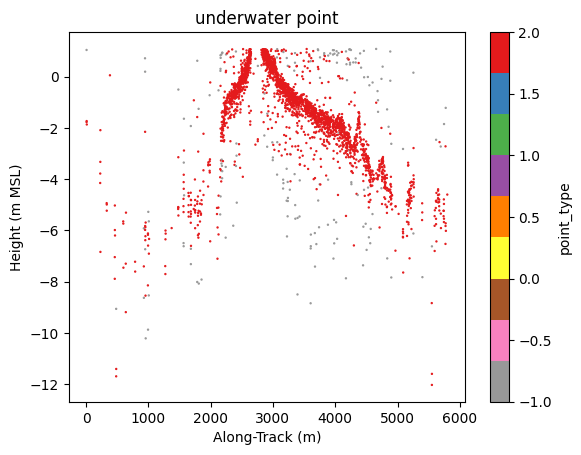

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'underwater point'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [18]:
from dataclasses import dataclass
from utils.denoise import PointType, get_normal_distribution
from utils.plot import get_plt

under_water_point = data.loc[data["point_type"] == PointType.LandSurface.value]

block = {}

for index, point in under_water_point.iterrows():
    id = point["Along-Track (m)"] // 10
    id = int(id)
    if id not in block:
        block[id] = []
    block[id].append(point)

new_ds = []
for id in block.keys():
    ds = pd.DataFrame(block[id])
    heights = ds["Height (m MSL)"].values
    mu, sigma = get_normal_distribution(heights)
    if sigma > 1:
        ds.loc[
            (ds["Height (m MSL)"] < mu - sigma) | (ds["Height (m MSL)"] > mu + sigma),
            "point_type",
        ] = PointType.Noise.value
    new_ds.append(ds)

seafloor_point = pd.concat(new_ds)

get_plt(
    seafloor_point, x="Along-Track (m)", y="Height (m MSL)", title="underwater point"
)

In [19]:
from dataclasses import dataclass

import rasterio
from pyproj import Transformer

@dataclass
class Point():
    lon: float
    lat: float

min_lat = seafloor_point["Latitude (deg)"].min()
max_lat = seafloor_point["Latitude (deg)"].max()
min_lon = seafloor_point["Longitude (deg)"].min()
max_lon = seafloor_point["Longitude (deg)"].max()

start_point = Point(lon=min_lon, lat=max_lat)
center_point = Point(lon=(min_lon + max_lon) / 2, lat=(min_lat + max_lat) / 2)

p1 = seafloor_point.iloc[100]
p2 = Point(lon=p1["Longitude (deg)"], lat=p1["Latitude (deg)"])

In [20]:
from utils.anti_rasterization import see_list

blocks = []
block_num = set()

for id in block.keys():
    ds = pd.DataFrame(block[id])
    block_num.add(len(ds))

    # icesat-2的激光点间隔是0.7m
    # 每个block大小是10m
    # 如果block的点数小于3个，说明这个block是无效的


    if len(ds) < 3:
        continue
    else:
        blocks.append(id)

print(f"有效的block数量: {len(blocks)}")
print(f"block内可能的数量: {block_num}")

bs = []
tmp = []
for id in blocks:
    if len(tmp) < 1:
        tmp.append(id)
        continue

    if id - tmp[-1] == 1:
        tmp.append(id)
    else:
        bs.append(tmp)
        tmp = []
        tmp.append(id)

see_list("有效的连续block_group", bs)

有效的block数量: 284
block内可能的数量: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}
有效的连续block_group中元素的个数:59
有效的连续block_group中元素的值:
[0]
[22]
[33]
[46]
[48]
[59]
[92]
[94, 95]
[99, 100]
[127]
[148]
[156, 157]
[164]
[168]
[174, 175]
[178, 179, 180]
[182]
[185]
[188]
[196]
[198]
[210]
[212]
[215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228]
[230, 231, 232, 233, 234]
[236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264]
[275]
[281]
[283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
[351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369]
[3

In [21]:
# 选择最大的连续区间
from utils.anti_rasterization import get_keypoint


select_ids = max(bs, key=len)
print(f"最大连续block的数量: {len(select_ids)}")

# 复制data.columns
key_points = pd.DataFrame(columns=data.columns)
for id in select_ids:
    ds = pd.DataFrame(block[id])
    kp = get_keypoint(ds).to_frame().T
    key_points = pd.concat([key_points, kp], ignore_index=True)

print(f"key_points:\n{key_points}")
print(f"key_points数量: {len(key_points)}")

save_csv(key_points, "keypoints", tag="")

最大连续block的数量: 67
key_points:
   Unnamed: 0.1 Unnamed: 0 Time (sec)  Delta Time (sec) Segment ID GT Num  \
0          9337       9450     0.3988  157661611.742542   883186.0   gt3r   
1          9359       9472     0.3995  157661611.743242   883186.0   gt3r   
2          9460       9574     0.4021  157661611.745842   883187.0   gt3r   
3          9507       9623     0.4035  157661611.747242   883188.0   gt3r   
4          9546       9662     0.4045  157661611.748242   883188.0   gt3r   
..          ...        ...        ...               ...        ...    ...   
62        11625      11764     0.4858  157661611.829542   883217.0   gt3r   
63        11649      11788     0.4868  157661611.830542   883217.0   gt3r   
64        11697      11836     0.4889  157661611.832642   883218.0   gt3r   
65        11730      11869     0.4905  157661611.834242   883218.0   gt3r   
66        11760      11899     0.4919  157661611.835642   883219.0   gt3r   

   Beam Num Beam Type Latitude (deg) Longitude

True

len of key_points: 67


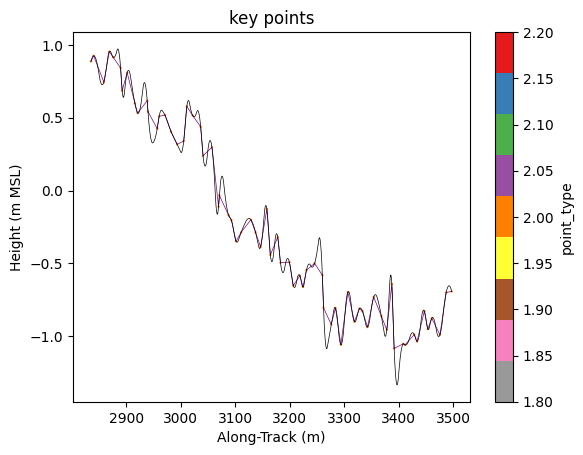

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'key points'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [22]:
print(f"len of key_points: {len(key_points)}")
get_plt(
    key_points,
    x="Along-Track (m)",
    y="Height (m MSL)",
    title="key points",
    curve=True,
    straight=True,
    k=2,
    bc_type="not-a-knot",
    interpolations=10000,
)